In [1]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import numpy as np
import math
import os

In [3]:
# for file in os.listdir('images/'):
#     #open target and reference images
#     target=cv2.imread('images/{}'.format(file))

In [4]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    #add model layers;filters =no. of nodes in the layer
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))#only if in keras.json image_data_format is channels_last; else if channels_first then 1,None,None
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    #input_shape takes image of any height and width as long it is one channel
    #that is how the SRCNN handles input,it handles image slice inputs, it doesn't work at all 3 channels at once
    #SRCNN was trained on the luminescence channel in the YCrCb color space 
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [5]:
# define necessary image processing functions

#necessary cuz when we run images through SRCNN based on the kernel sizes and 
#convulational layers, we are going to lose some of these outside pixels
#the images are going to get smaller and that's why it is neccesary to have 
#a divisible image size 
def modcrop(img,scale):
    #temp size
    tmpsz=img.shape
    sz=tmpsz[0:2]
    #ensures that dimension of our image are divisible by scale
    #(doesn't leaves hanging remainders) by cropping the images size
    #np.mod returns the remainder bewtween our sz and scale
    mod = np.mod(sz,scale)
    if(mod[0] > 1 or mod[1] >1):
        sz=sz-np.mod(sz,scale)
        img=img[0:sz[0],1:sz[1]]
    return img

#crop offs the bordersize from all sides of the image
def shave(image,border):
    img=image[border: -border,border:-border]
    return img

In [6]:
def predict(image_path):
    
    #load the srcnn model with weights cuz deep learning neural n/w take lot of time to train(have to feed in large amount of input data)
    srcnn=model()
    srcnn.load_weights('3051crop_weight_200.h5')
     
    #load the degraded and reference images
    #in opencv, images are loaded as BGR channels
    path,file=os.path.split(image_path)
    degraded=cv2.imread('source/{}'.format(file))
    
    #preprocess the image with modcrop
    degraded=modcrop(degraded,3)
    
    #convert the image to YCrCb(3 channel image) - (srcnn trained on Y channel)
    temp=cv2.cvtColor(degraded,cv2.COLOR_BGR2YCrCb)
    #opencv does a very good job in converting from rgb to YCrCb and back
    
    #create image slice and normalize cuz SRCNN works on one dimensional input(or 3D inputs of depth 1 ,ie, inputs with one channel)
    Y=numpy.zeros((1,temp.shape[0],temp.shape[1],1),dtype=float)
    #create a numpy array the we fill with data,temp.shape[0]=width,[1]=height and last one means one channel(essentially like batch=1 cuz that's what going to get passed to the n/w ')
    #fill in the data; all values are normalized to between 0 and 1 as that's how srcnn was trained
    Y[0,:,:,0]=temp[:,:,0].astype(float)/255
    #first 0 means 0th index(we are saying that batch size is 1); :,: means every point in these channels; last 0 means first channel,ie, all the pixels in first luminescence channel
    #so we have our image slice, we have the Y channel, which is the first channel(index 0) out of the image that we converted to YCrCb color space
    
    #perform super-resolution with srcnn
    pre=srcnn.predict(Y,batch_size=1)#that's why we had index 0  above cuz we are saying that batch size is 1
    
    #post-process output cuz pre is still normalized
    pre*=255#multiplying every pixel by 255
    pre[pre[:]>255]=255#any pixels >255 set it =255 to prevent any rounding errors due to multiplication
    pre[pre[:]<0] =0# same reason as above
    pre=pre.astype(np.uint8)#convert float back to int values
    
    #cuz this is only the luminescence channel in the pre ,SO
    #copy Y channel back to image and convert to BGR
    temp=shave(temp,6)#accd.to tutor it loses 3 pixels on each side so if we shave this with a border 6,we can crop it appropriately there, so it is the same size as our output
    #if not agree with tutor, use print statements to see the specific dimensions
    
    # for the first channel(Y channel), copy in the output of our network
    temp[:,:,0]=pre[0,:,:,0]
    #So we are keeping the red difference and blue difference, channels 1 and 2, in this temp image which is in the YCrCb color space
    #and in the first one we are copying in our ouput,our luminiscence channel
    
    #convert back to bgr
    output=cv2.cvtColor(temp,cv2.COLOR_YCrCb2BGR)
    
    #emove borderfrom reference and degraded image, so that all our images(ref,degraded(low res.), and ouput(high res.)) are of the same size
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # return images and scores
    return degraded, output

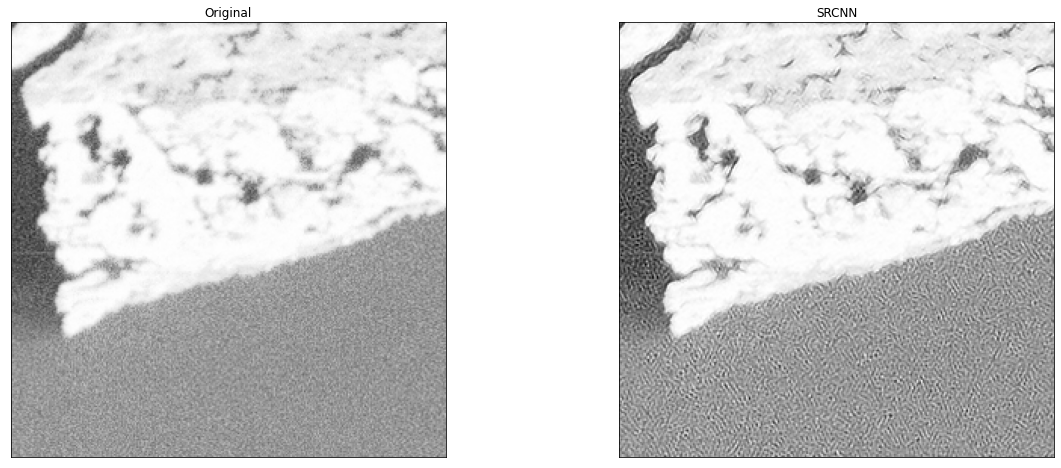

In [11]:
for file in os.listdir('source'):
    
    # perform super-resolution
    ref, output = predict('source/{}'.format(file))
    
    cv2.imwrite('output/{}'.format(file), output) 
    # display images as subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[1].set_title('SRCNN')
    
    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])